<a href="https://colab.research.google.com/github/seven320/air_pollutants/blob/main/FP001_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Apr 16 10:02:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [292]:
import os, sys
COLAB = "google.colab" in sys.modules

if COLAB:
    from google.colab import drive
    from google.colab import output
    drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [293]:
if COLAB:
    !pip install transformers > /dev/null
    !pip install einops > /dev/null
    !pip install timm > /dev/null
    !pip install kaggle > /dev/null
    !pip install kaggle_datasets > /dev/null
    !pip install git+https://github.com/albumentations-team/albumentations
    !pip install tensorflow-determinism
    !pip install -q iterative-stratification
    output.clear()

In [294]:
import gc
import json
import math
import os
import random
import re
import time
import copy
import warnings
from requests import get
from contextlib import contextmanager
from typing import List, Optional, TypeVar, Type

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold, train_test_split, KFold
from sklearn.preprocessing import RobustScaler, LabelEncoder
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from einops.layers.torch import Rearrange, Reduce
import timm

from tqdm.notebook import tqdm
from transformers import AdamW, get_cosine_schedule_with_warmup
from typing import Optional, Tuple
from xgboost import XGBRegressor
import lightgbm as lgb

In [295]:
warnings.simplefilter('ignore')

In [296]:
if COLAB:    
    NOTEBOOK_NAME = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
    print(NOTEBOOK_NAME)

FP001-basic


In [297]:
COMPE_NAME = "air_pollutants"
BASE_DIR = f"/content/drive/MyDrive/signate/{COMPE_NAME}"

# KAGGLE ONLY HAS 1, BUT OFFLINE, YOU CAN USE MORE
os.environ["CUDA_VISIBLE_DEVICES"]="0" #0,1,2,3 for four gpu

In [298]:
if COLAB:
    INPUT_DIR = Path(os.path.join(BASE_DIR ,f"input"))
    INPUT_DIR.mkdir(exist_ok=True, parents=True)

    SAVE_DIR = Path(os.path.join(BASE_DIR ,f"models/{NOTEBOOK_NAME}"))
    SAVE_DIR.mkdir(exist_ok=True, parents=True)

    OOF_DIR = Path(os.path.join(BASE_DIR, f"oof/{NOTEBOOK_NAME}"))
    OOF_DIR.mkdir(exist_ok=True, parents = True)

    SUB_DIR = Path(os.path.join(BASE_DIR, f"submission/{NOTEBOOK_NAME}"))
    SUB_DIR.mkdir(exist_ok=True, parents = True)

In [299]:
train_df = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(INPUT_DIR, "test.csv"))
sample_df = pd.read_csv(os.path.join(INPUT_DIR, "submit_sample.csv"), names=["id", "predict"])

In [300]:
# Config

NUM_FOLDS = 5

In [301]:
#############
## Utility ##
#############
@contextmanager
def timer(name: str):
    t0 = time.time()
    print(f"[{name}] start")
    yield
    print(f"[{name}] done - elapsed {time.time() - t0:.2f}s")

In [302]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [303]:
train_df.head()

,id,year,month,day,Country,City,lat,lon,co_cnt,co_min,...,ws_min,ws_mid,ws_max,ws_var,dew_cnt,dew_min,dew_mid,dew_max,dew_var,pm25_mid
0,1,2019,1,1,Australia,Brisbane,-27.46794,153.02809,38,0.749,...,0.241,1.088,3.101,1.983,17,7.671,10.358,15.112,13.424,19.901
1,2,2019,1,1,Australia,Darwin,-12.46113,130.84185,47,2.594,...,0.828,3.473,7.396,10.411,62,21.324,23.813,24.221,2.021,13.741
2,3,2019,1,1,Australia,Melbourne,-37.81400,144.96332,17,1.190,...,0.000,2.107,8.089,15.719,22,10.309,13.133,15.422,6.355,25.918
3,4,2019,1,1,Australia,Newcastle,-32.92953,151.78010,63,4.586,...,0.284,0.503,3.592,2.485,116,7.146,10.685,13.344,9.417,174.370
4,5,2019,1,1,Australia,Perth,-31.95224,115.86140,47,4.689,...,0.500,0.755,3.396,1.937,93,1.091,3.277,12.272,4.109,167.063


In [304]:
train_city = train_df["City"].unique().tolist()
test_city = test_df["City"].unique().tolist()

train_city_cnt = len(train_city)
test_city_cnt = len(test_city)

print(f"train city count: {train_city_cnt}")
print(f"test city count: {test_city_cnt}")

print(f"{len(set(train_city) & set(test_city))}")

train city count: 239
test city count: 63
0


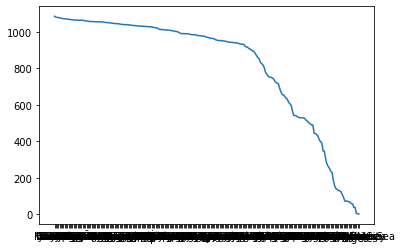

In [305]:
plt.plot(train_df["City"].value_counts())

In [306]:
kf = GroupKFold(n_splits = NUM_FOLDS)

folds = copy.deepcopy(train_df[["id"]])
folds["kfold"] = -1

for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df, train_df["pm25_mid"], train_df["City"])):

    print(f"train_idx: {len(train_idx)}, valid_idx: {len(valid_idx)}")
    folds.loc[valid_idx, "kfold"] = fold

train_df = train_df.merge(folds[["id", "kfold"]], on="id", how="left")

train_idx: 156755, valid_idx: 39186
train_idx: 156758, valid_idx: 39183
train_idx: 156760, valid_idx: 39181
train_idx: 156730, valid_idx: 39211
train_idx: 156761, valid_idx: 39180


# Train

In [307]:
import logging
from typing import List, Optional, TypeVar

import pandas as pd

class AbstractFeatureTransformer:
    def __init__(self):
        self.name = self.__class__.__name__

    def fit_transform(self, input_df: pd.DataFrame, y=None):
        self.fit(input_df, y)
        return self.transform(input_df)

    def fit(self, input_df: pd.DataFrame, y=None):
        pass

    def transform(self, input_df: pd.DataFrame) -> pd.DataFrame:
        raise NotImplementedError

Transformer = TypeVar("Transformer", bound=AbstractFeatureTransformer)

def extract_features(input_df: pd.DataFrame,
                     transformers: List[Transformer],
                     fit: bool = True,
                     logger: Optional[logging.Logger] = None):
    feature_dfs = []
    for transformer in transformers:
        # timerはブロックの実行時間を計測するユーティリティ
        with timer(f"Extract features with {transformer.name}", logger):
            if fit:
                feature_dfs.append(transformer.fit_transform(input_df))
            else:
                feature_dfs.append(transformer.transform(input_df))
    all_features = pd.concat(feature_dfs, axis=1)
    return all_features

In [308]:
class Numericals(AbstractFeatureTransformer):
    def transform(self, input_df: pd.DataFrame) -> pd.DataFrame:
        cols = [pd.api.types.is_numeric_dtype(dtype) for dtype in input_df.dtypes]
        return input_df.loc[:, cols]

class LabelEncoding(AbstractFeatureTransformer):
    def __init__(self, columns: List[str]):
        super().__init__()
        self.le_columns = columns
        self.encoders = {
            column: LabelEncoder()
            for column in self.le_columns
        }
        self.__is_fitted = False

    def fit(self, input_df: pd.DataFrame, y: Optional[np.ndarray] = None):
        """
        ラベルに変換する前に欠損値を埋める
        """

        for column in self.le_columns:
            self.encoders[column].fit(input_df[column].fillna(""))
        self.__is_fitted = True

    def transform(
        self, 
        input_df: pd.DataFrame, 
        y: Optional[np.ndarray] = None
    ) -> pd.DataFrame:
        assert self.__is_fitted, "You need to call `fit` first."
        encoded = {}
        for column in self.le_columns:
            encoded[column] = self.encoders[column].transform(
                input_df[column].fillna(""))
        return pd.DataFrame(encoded)

In [309]:
train_df.head(5)

,id,year,month,day,Country,City,lat,lon,co_cnt,co_min,...,ws_mid,ws_max,ws_var,dew_cnt,dew_min,dew_mid,dew_max,dew_var,pm25_mid,kfold
0,1,2019,1,1,Australia,Brisbane,-27.46794,153.02809,38,0.749,...,1.088,3.101,1.983,17,7.671,10.358,15.112,13.424,19.901,0
1,2,2019,1,1,Australia,Darwin,-12.46113,130.84185,47,2.594,...,3.473,7.396,10.411,62,21.324,23.813,24.221,2.021,13.741,2
2,3,2019,1,1,Australia,Melbourne,-37.81400,144.96332,17,1.190,...,2.107,8.089,15.719,22,10.309,13.133,15.422,6.355,25.918,2
3,4,2019,1,1,Australia,Newcastle,-32.92953,151.78010,63,4.586,...,0.503,3.592,2.485,116,7.146,10.685,13.344,9.417,174.370,1
4,5,2019,1,1,Australia,Perth,-31.95224,115.86140,47,4.689,...,0.755,3.396,1.937,93,1.091,3.277,12.272,4.109,167.063,1


In [310]:
# numericals = Numericals()
# 数字に関する変換
# train_df_num = numericals.transform(train_df)

# ラベルに関する変換
# labelencoding = LabelEncoding(columns = [])

# labelencoding.fit(train_df_num)
# train_df_labeled = labelencoding.transform(train_df_num)

In [311]:
class AbstractTreeModel:
    def __init__(self, prediction_type="regression"):
        self.model = None
        self.prediction_type = prediction_type

    def train(self,
              params: dict,
              X_train: pd.DataFrame,
              y_train: np.ndarray,
              X_val: pd.DataFrame,
              y_val: np.ndarray,
              train_weights: Optional[np.ndarray] = None,
              val_weights: Optional[np.ndarray] = None,
              train_params: Optional[dict] = None):
        if train_params is None:
            train_params = {}

        model = self._train(
            params,
            X_train, y_train,
            X_val, y_val,
            train_weights, val_weights,
            train_params)
        self.model = model
        return self

    def _train(self,
               params,
               X_train,
               y_train,
               X_val,
               y_val,
               train_weights,
               val_weights,
               train_params):
        raise NotImplementedError

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        raise NotImplementedError

    @property
    def feature_names_(self):
        raise NotImplementedError

    @property
    def feature_importances_(self):
        raise NotImplementedError

    def _check_if_trained(self):
        assert self.model is not None, "You need to train the model first"


class LGBModel(AbstractTreeModel):
    def _train(self,
               params,
               X_train, y_train,
               X_val, y_val,
               train_weights, val_weights,
               train_params):
        trn_data = lgb.Dataset(X_train, y_train, weight=train_weights)
        val_data = lgb.Dataset(X_val, y_val, weight=val_weights)
        model = lgb.train(params=params,
                          train_set=trn_data,
                          valid_sets=[trn_data, val_data],
                          **train_params)
        return model

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        self._check_if_trained()
        return self.model.predict(X, num_iteration=self.model.best_iteration)

    @property
    def feature_names_(self):
        self._check_if_trained()
        return self.model.feature_name()

    @property
    def feature_importances_(self):
        self._check_if_trained()
        return self.model.feature_importance(importance_type="gain")


def get_tree_model(name: str) -> Type[AbstractTreeModel]:
    DEFINED_MODELS = {
        "lgb": LGBModel,
        # 実装していない
        # "xgb": XGBModel,
        # "cat": CatBoostModel
    }
    model = DEFINED_MODELS.get(name)
    if model is None:
        raise ValueError(
            """Invalid model name: {}.
            Pre-defined model names are as follows: {}""".format(
                name,
                ",".join(DEFINED_MODELS.keys())
            ))
    return model

In [312]:
def show_feature_importance(model: AbstractTreeModel):
    feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, model.feature_names_)), columns=['Value','Feature'])
    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()
    # plt.savefig('lgbm_importances-01.png')

In [313]:
parameters = {
            'objective': 'rmse',
            'metric': 'rmse',
            'max_bin': 255,
            'n_estimators':5000,
            'learning_rate': 0.03,
            'max_depth': 16,
            'num_leaves': 8,
            'early_stopping_rounds': 30,
            'verbosity': 10
        }

In [314]:
lgb_model = get_tree_model("lgb")()

cat_cols = [c for c in train_df.columns if train_df[c].dtype == np.object]

num_cols = [c for c in train_df.columns if train_df[c].dtype != np.object]
num_cols.remove("id")
num_cols.remove("kfold")
num_cols.remove("pm25_mid")

target_cols = "pm25_mid"

In [367]:
lgb_models = []

oof_df = train_df[["id"]]
oof_df["oof"] = -1

for i in range(NUM_FOLDS):
    train_data = train_df[train_df["kfold"] != i].reset_index(drop = True)
    valid_data = train_df[train_df["kfold"] == i].reset_index(drop = True)

    print(f"train_data nums: {len(train_data)}, valid_data nums: {len(valid_data)}")

    lgb_model.train(
        params = parameters,
        X_train = train_data[num_cols],
        y_train = train_data[target_cols],
        X_val = valid_data[num_cols],
        y_val = valid_data[target_cols],
    )
    lgb_models.append(lgb_model)

    oof = lgb_model.predict(
        valid_data[num_cols]
    )
    oof_df.loc[train_df["kfold"] == i, "oof"] = oof

train_oof = train_df.merge(oof_df[["id", "oof"]], on = "id", how = "left")

ストリーミング出力は最後の 5000 行に切り捨てられました。
[1121]	training's rmse: 20.2989	valid_1's rmse: 22.6366
[1122]	training's rmse: 20.2983	valid_1's rmse: 22.6368
[1123]	training's rmse: 20.2973	valid_1's rmse: 22.6366
[1124]	training's rmse: 20.2962	valid_1's rmse: 22.6374
[1125]	training's rmse: 20.2948	valid_1's rmse: 22.6351
[1126]	training's rmse: 20.2935	valid_1's rmse: 22.6341
[1127]	training's rmse: 20.292	valid_1's rmse: 22.6325
[1128]	training's rmse: 20.29	valid_1's rmse: 22.6309
[1129]	training's rmse: 20.2884	valid_1's rmse: 22.6287
[1130]	training's rmse: 20.287	valid_1's rmse: 22.6294
[1131]	training's rmse: 20.286	valid_1's rmse: 22.6288
[1132]	training's rmse: 20.2846	valid_1's rmse: 22.6285
[1133]	training's rmse: 20.2835	valid_1's rmse: 22.6278
[1134]	training's rmse: 20.2816	valid_1's rmse: 22.6261
[1135]	training's rmse: 20.281	valid_1's rmse: 22.626
[1136]	training's rmse: 20.28	valid_1's rmse: 22.6258
[1137]	training's rmse: 20.2784	valid_1's rmse: 22.6258
[1138]	training's rmse: 2

In [368]:
train_oof.head()

,id,year,month,day,Country,City,lat,lon,co_cnt,co_min,...,ws_max,ws_var,dew_cnt,dew_min,dew_mid,dew_max,dew_var,pm25_mid,kfold,oof
0,1,2019,1,1,Australia,Brisbane,-27.46794,153.02809,38,0.749,...,3.101,1.983,17,7.671,10.358,15.112,13.424,19.901,0,18.676469
1,2,2019,1,1,Australia,Darwin,-12.46113,130.84185,47,2.594,...,7.396,10.411,62,21.324,23.813,24.221,2.021,13.741,2,33.493032
2,3,2019,1,1,Australia,Melbourne,-37.81400,144.96332,17,1.190,...,8.089,15.719,22,10.309,13.133,15.422,6.355,25.918,2,22.540358
3,4,2019,1,1,Australia,Newcastle,-32.92953,151.78010,63,4.586,...,3.592,2.485,116,7.146,10.685,13.344,9.417,174.370,1,141.741671
4,5,2019,1,1,Australia,Perth,-31.95224,115.86140,47,4.689,...,3.396,1.937,93,1.091,3.277,12.272,4.109,167.063,1,156.812907


In [369]:
train_oof[["id","pm25_mid", "kfold", "oof"]].to_csv(os.path.join(OOF_DIR, "oof.csv"), index= False)

# predict

In [370]:
sum_predict = None
for lgb_model in lgb_models:
    predict = lgb_model.predict(
        test_df[num_cols],
    )
    if sum_predict is None:
        sum_predict = predict
    else:
        sum_predict += predict

mean_predict = sum_predict / len(lgb_models)

In [371]:
sample_df.loc[:,"predict"] = mean_predict

In [372]:
sample_df.head()

,id,predict
0,195942,14.938545
1,195943,38.438723
2,195944,26.125644
3,195945,67.638404
4,195946,131.132004


In [373]:
sample_df.to_csv(os.path.join(SUB_DIR, "submission.csv"), index= False, header = False)

In [374]:
!pip install signate > /dev/null
!mkdir /root/.signate
!cp /content/drive/MyDrive/signate/signate.json /root/.signate/signate.json

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.9 which is incompatible.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
mkdir: cannot create directory ‘/root/.signate’: File exists


In [375]:
submission_file = os.path.join(SUB_DIR, "submission.csv")

In [379]:
comment = "mean_5folds"

In [380]:
!signate submit --competition-id=624 {submission_file} --note {comment}

You have successfully submitted your predictions.We will send you the submission result to your email address.
